In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
from scipy.misc import imread
import matplotlib.patches as patches
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam
import cv2
from pycrayon import CrayonClient
from torch.utils.data import DataLoader
from faster_rcnn.network import  clip_gradient
import torch

def collate_fn(batch):
    return batch

In [3]:
import os
import torchvision.transforms as transforms
from faster_rcnn.utils.dataset import CocoData
from faster_rcnn.utils.data_generator import CocoGenerator
from faster_rcnn.utils.data_generator import Enqueuer

dataDir = './data/mscoco'
dataType = 'train2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
# pre_proposal_folder = './data/mscoco/coco_proposals/MCG/'

images_dir = os.path.join(dataDir,'images', dataType)
cap = CocoData(root = images_dir,
                        annFile = annFile,
#                         pre_proposal_folder=pre_proposal_folder,
                        transform=transforms.ToTensor())



data_gen = CocoGenerator(data=cap)
queue = Enqueuer(generator=data_gen)
queue.start(max_queue_size=10, workers=2)
t = queue.get()


/data
/data/data/mscoco
loading annotations into memory...
Done (t=12.56s)
creating index...
index created!


In [4]:
from faster_rcnn.faster_rcnn import  RPN

In [5]:
cc = CrayonClient(hostname="crayon", port=8889)
try:
    exp = cc.create_experiment("RPN")
except: 
    cc.remove_experiment("RPN")
    exp = cc.create_experiment("RPN")

disp_interval = 100
log_interval = 10

In [6]:
net = RPN()
net.cuda()
net.train()

RPN (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [7]:
param = filter(lambda x: x.requires_grad, net.parameters())

In [8]:
optimizer = SGD(param, lr=1e-4, momentum=0.9, weight_decay=0.0005)

In [9]:
def train(data_gen, optimizer, model, epoch):
    model.train()
    train_loss = 0
    losses = []
    for step in range(1, epoch):
#         blobs = data_gen.next()
        blobs = cap[13499]
        if blobs is None:
            continue
        if step > epoch:
            break
        im_data = blobs['data']
        im_info = blobs['im_info']
        gt_boxes = np.hstack([ blobs['boxes'] , blobs['gt_classes'][:, np.newaxis]])
        gt_ishard = blobs['gt_ishard']
        dontcare_areas = blobs['dontcare_areas']
        output = model(im_data, im_info, gt_boxes)
        loss = model.loss
        print 'loss', loss
        train_loss += loss.data[0]
        optimizer.zero_grad()
        loss.backward()
        clip_gradient(model, 10.)
        optimizer.step()
        loss_value = loss.data.cpu().float()
        losses.append(loss_value)
        
        if step % 1 == 0:

            log_text = 'step %d, image: %s, loss: %.4f' % (
                step, blobs['im_name'], train_loss /(step))
            print(log_text)

            re_cnt = True

#         if step % log_interval == 0:
#             exp.add_scalar_value('loss', loss.data[0], step=step)
#             exp.add_scalar_value('last_layers_loss', net.loss.data[0], step=step)

In [10]:
train(t, optimizer, net, 100)

rpn_cls_score.shape (1, 24, 37, 50)
image info [[ 600.    800.      1.25]]
anchors:
[[ -38.  -16.   53.   31.]
 [ -84.  -40.   99.   55.]
 [-176.  -88.  191.  103.]
 [-360. -184.  375.  199.]
 [ -24.  -24.   39.   39.]
 [ -56.  -56.   71.   71.]
 [-120. -120.  135.  135.]
 [-248. -248.  263.  263.]
 [ -14.  -36.   29.   51.]
 [ -36.  -80.   51.   95.]
 [ -80. -168.   95.  183.]
 [-168. -344.  183.  359.]]
anchor shapes:
[[  91.   47.]
 [ 183.   95.]
 [ 367.  191.]
 [ 735.  383.]
 [  63.   63.]
 [ 127.  127.]
 [ 255.  255.]
 [ 511.  511.]
 [  43.   87.]
 [  87.  175.]
 [ 175.  351.]
 [ 351.  703.]]
AnchorTargetLayer: height 37 width 50

im_size: (600.0, 800.0)
scale: 1.25
height, width: (37, 50)
rpn: gt_boxes.shape (3, 5)
rpn: gt_boxes [[ 140.    253.75  185.    430.     24.  ]
 [ 318.75  247.5   442.5   388.75   24.  ]
 [ 397.5   242.5   571.25  395.     24.  ]]
total_anchors 22200
inds_inside 10584
anchors.shape (10584, 4)
gt_argmax_overlaps (10,)
cfg.TRAIN.RPN_FG_FRACTION , cfg.TRAIN

rpn_cls_score.shape (1, 24, 37, 50)
image info [[ 600.    800.      1.25]]
anchors:
[[ -38.  -16.   53.   31.]
 [ -84.  -40.   99.   55.]
 [-176.  -88.  191.  103.]
 [-360. -184.  375.  199.]
 [ -24.  -24.   39.   39.]
 [ -56.  -56.   71.   71.]
 [-120. -120.  135.  135.]
 [-248. -248.  263.  263.]
 [ -14.  -36.   29.   51.]
 [ -36.  -80.   51.   95.]
 [ -80. -168.   95.  183.]
 [-168. -344.  183.  359.]]
anchor shapes:
[[  91.   47.]
 [ 183.   95.]
 [ 367.  191.]
 [ 735.  383.]
 [  63.   63.]
 [ 127.  127.]
 [ 255.  255.]
 [ 511.  511.]
 [  43.   87.]
 [  87.  175.]
 [ 175.  351.]
 [ 351.  703.]]
AnchorTargetLayer: height 37 width 50

im_size: (600.0, 800.0)
scale: 1.25
height, width: (37, 50)
rpn: gt_boxes.shape (3, 5)
rpn: gt_boxes [[ 140.    253.75  185.    430.     24.  ]
 [ 318.75  247.5   442.5   388.75   24.  ]
 [ 397.5   242.5   571.25  395.     24.  ]]
total_anchors 22200
inds_inside 10584
anchors.shape (10584, 4)
gt_argmax_overlaps (10,)
cfg.TRAIN.RPN_FG_FRACTION , cfg.TRAIN

step 10, image: COCO_train2014_000000309241.jpg, loss: 4.0444
rpn_cls_score.shape (1, 24, 37, 50)
image info [[ 600.    800.      1.25]]
anchors:
[[ -38.  -16.   53.   31.]
 [ -84.  -40.   99.   55.]
 [-176.  -88.  191.  103.]
 [-360. -184.  375.  199.]
 [ -24.  -24.   39.   39.]
 [ -56.  -56.   71.   71.]
 [-120. -120.  135.  135.]
 [-248. -248.  263.  263.]
 [ -14.  -36.   29.   51.]
 [ -36.  -80.   51.   95.]
 [ -80. -168.   95.  183.]
 [-168. -344.  183.  359.]]
anchor shapes:
[[  91.   47.]
 [ 183.   95.]
 [ 367.  191.]
 [ 735.  383.]
 [  63.   63.]
 [ 127.  127.]
 [ 255.  255.]
 [ 511.  511.]
 [  43.   87.]
 [  87.  175.]
 [ 175.  351.]
 [ 351.  703.]]
AnchorTargetLayer: height 37 width 50

im_size: (600.0, 800.0)
scale: 1.25
height, width: (37, 50)
rpn: gt_boxes.shape (3, 5)
rpn: gt_boxes [[ 140.    253.75  185.    430.     24.  ]
 [ 318.75  247.5   442.5   388.75   24.  ]
 [ 397.5   242.5   571.25  395.     24.  ]]
total_anchors 22200
inds_inside 10584
anchors.shape (10584, 4)


step 16, image: COCO_train2014_000000309241.jpg, loss: 3.2490
rpn_cls_score.shape (1, 24, 37, 50)
image info [[ 600.    800.      1.25]]
anchors:
[[ -38.  -16.   53.   31.]
 [ -84.  -40.   99.   55.]
 [-176.  -88.  191.  103.]
 [-360. -184.  375.  199.]
 [ -24.  -24.   39.   39.]
 [ -56.  -56.   71.   71.]
 [-120. -120.  135.  135.]
 [-248. -248.  263.  263.]
 [ -14.  -36.   29.   51.]
 [ -36.  -80.   51.   95.]
 [ -80. -168.   95.  183.]
 [-168. -344.  183.  359.]]
anchor shapes:
[[  91.   47.]
 [ 183.   95.]
 [ 367.  191.]
 [ 735.  383.]
 [  63.   63.]
 [ 127.  127.]
 [ 255.  255.]
 [ 511.  511.]
 [  43.   87.]
 [  87.  175.]
 [ 175.  351.]
 [ 351.  703.]]
AnchorTargetLayer: height 37 width 50

im_size: (600.0, 800.0)
scale: 1.25
height, width: (37, 50)
rpn: gt_boxes.shape (3, 5)
rpn: gt_boxes [[ 140.    253.75  185.    430.     24.  ]
 [ 318.75  247.5   442.5   388.75   24.  ]
 [ 397.5   242.5   571.25  395.     24.  ]]
total_anchors 22200
inds_inside 10584
anchors.shape (10584, 4)


step 22, image: COCO_train2014_000000309241.jpg, loss: 2.5613
rpn_cls_score.shape (1, 24, 37, 50)
image info [[ 600.    800.      1.25]]
anchors:
[[ -38.  -16.   53.   31.]
 [ -84.  -40.   99.   55.]
 [-176.  -88.  191.  103.]
 [-360. -184.  375.  199.]
 [ -24.  -24.   39.   39.]
 [ -56.  -56.   71.   71.]
 [-120. -120.  135.  135.]
 [-248. -248.  263.  263.]
 [ -14.  -36.   29.   51.]
 [ -36.  -80.   51.   95.]
 [ -80. -168.   95.  183.]
 [-168. -344.  183.  359.]]
anchor shapes:
[[  91.   47.]
 [ 183.   95.]
 [ 367.  191.]
 [ 735.  383.]
 [  63.   63.]
 [ 127.  127.]
 [ 255.  255.]
 [ 511.  511.]
 [  43.   87.]
 [  87.  175.]
 [ 175.  351.]
 [ 351.  703.]]
AnchorTargetLayer: height 37 width 50

im_size: (600.0, 800.0)
scale: 1.25
height, width: (37, 50)
rpn: gt_boxes.shape (3, 5)
rpn: gt_boxes [[ 140.    253.75  185.    430.     24.  ]
 [ 318.75  247.5   442.5   388.75   24.  ]
 [ 397.5   242.5   571.25  395.     24.  ]]
total_anchors 22200
inds_inside 10584
anchors.shape (10584, 4)


step 28, image: COCO_train2014_000000309241.jpg, loss: 2.0709
rpn_cls_score.shape (1, 24, 37, 50)
image info [[ 600.    800.      1.25]]
anchors:
[[ -38.  -16.   53.   31.]
 [ -84.  -40.   99.   55.]
 [-176.  -88.  191.  103.]
 [-360. -184.  375.  199.]
 [ -24.  -24.   39.   39.]
 [ -56.  -56.   71.   71.]
 [-120. -120.  135.  135.]
 [-248. -248.  263.  263.]
 [ -14.  -36.   29.   51.]
 [ -36.  -80.   51.   95.]
 [ -80. -168.   95.  183.]
 [-168. -344.  183.  359.]]
anchor shapes:
[[  91.   47.]
 [ 183.   95.]
 [ 367.  191.]
 [ 735.  383.]
 [  63.   63.]
 [ 127.  127.]
 [ 255.  255.]
 [ 511.  511.]
 [  43.   87.]
 [  87.  175.]
 [ 175.  351.]
 [ 351.  703.]]
AnchorTargetLayer: height 37 width 50

im_size: (600.0, 800.0)
scale: 1.25
height, width: (37, 50)
rpn: gt_boxes.shape (3, 5)
rpn: gt_boxes [[ 140.    253.75  185.    430.     24.  ]
 [ 318.75  247.5   442.5   388.75   24.  ]
 [ 397.5   242.5   571.25  395.     24.  ]]
total_anchors 22200
inds_inside 10584
anchors.shape (10584, 4)


step 34, image: COCO_train2014_000000309241.jpg, loss: 1.7260
rpn_cls_score.shape (1, 24, 37, 50)
image info [[ 600.    800.      1.25]]
anchors:
[[ -38.  -16.   53.   31.]
 [ -84.  -40.   99.   55.]
 [-176.  -88.  191.  103.]
 [-360. -184.  375.  199.]
 [ -24.  -24.   39.   39.]
 [ -56.  -56.   71.   71.]
 [-120. -120.  135.  135.]
 [-248. -248.  263.  263.]
 [ -14.  -36.   29.   51.]
 [ -36.  -80.   51.   95.]
 [ -80. -168.   95.  183.]
 [-168. -344.  183.  359.]]
anchor shapes:
[[  91.   47.]
 [ 183.   95.]
 [ 367.  191.]
 [ 735.  383.]
 [  63.   63.]
 [ 127.  127.]
 [ 255.  255.]
 [ 511.  511.]
 [  43.   87.]
 [  87.  175.]
 [ 175.  351.]
 [ 351.  703.]]
AnchorTargetLayer: height 37 width 50

im_size: (600.0, 800.0)
scale: 1.25
height, width: (37, 50)
rpn: gt_boxes.shape (3, 5)
rpn: gt_boxes [[ 140.    253.75  185.    430.     24.  ]
 [ 318.75  247.5   442.5   388.75   24.  ]
 [ 397.5   242.5   571.25  395.     24.  ]]
total_anchors 22200
inds_inside 10584
anchors.shape (10584, 4)


step 40, image: COCO_train2014_000000309241.jpg, loss: 1.4778
rpn_cls_score.shape (1, 24, 37, 50)
image info [[ 600.    800.      1.25]]
anchors:
[[ -38.  -16.   53.   31.]
 [ -84.  -40.   99.   55.]
 [-176.  -88.  191.  103.]
 [-360. -184.  375.  199.]
 [ -24.  -24.   39.   39.]
 [ -56.  -56.   71.   71.]
 [-120. -120.  135.  135.]
 [-248. -248.  263.  263.]
 [ -14.  -36.   29.   51.]
 [ -36.  -80.   51.   95.]
 [ -80. -168.   95.  183.]
 [-168. -344.  183.  359.]]
anchor shapes:
[[  91.   47.]
 [ 183.   95.]
 [ 367.  191.]
 [ 735.  383.]
 [  63.   63.]
 [ 127.  127.]
 [ 255.  255.]
 [ 511.  511.]
 [  43.   87.]
 [  87.  175.]
 [ 175.  351.]
 [ 351.  703.]]
AnchorTargetLayer: height 37 width 50

im_size: (600.0, 800.0)
scale: 1.25
height, width: (37, 50)
rpn: gt_boxes.shape (3, 5)
rpn: gt_boxes [[ 140.    253.75  185.    430.     24.  ]
 [ 318.75  247.5   442.5   388.75   24.  ]
 [ 397.5   242.5   571.25  395.     24.  ]]
total_anchors 22200
inds_inside 10584
anchors.shape (10584, 4)


step 46, image: COCO_train2014_000000309241.jpg, loss: 1.2893
rpn_cls_score.shape (1, 24, 37, 50)
image info [[ 600.    800.      1.25]]
anchors:
[[ -38.  -16.   53.   31.]
 [ -84.  -40.   99.   55.]
 [-176.  -88.  191.  103.]
 [-360. -184.  375.  199.]
 [ -24.  -24.   39.   39.]
 [ -56.  -56.   71.   71.]
 [-120. -120.  135.  135.]
 [-248. -248.  263.  263.]
 [ -14.  -36.   29.   51.]
 [ -36.  -80.   51.   95.]
 [ -80. -168.   95.  183.]
 [-168. -344.  183.  359.]]
anchor shapes:
[[  91.   47.]
 [ 183.   95.]
 [ 367.  191.]
 [ 735.  383.]
 [  63.   63.]
 [ 127.  127.]
 [ 255.  255.]
 [ 511.  511.]
 [  43.   87.]
 [  87.  175.]
 [ 175.  351.]
 [ 351.  703.]]
AnchorTargetLayer: height 37 width 50

im_size: (600.0, 800.0)
scale: 1.25
height, width: (37, 50)
rpn: gt_boxes.shape (3, 5)
rpn: gt_boxes [[ 140.    253.75  185.    430.     24.  ]
 [ 318.75  247.5   442.5   388.75   24.  ]
 [ 397.5   242.5   571.25  395.     24.  ]]
total_anchors 22200
inds_inside 10584
anchors.shape (10584, 4)


step 52, image: COCO_train2014_000000309241.jpg, loss: 1.1439
rpn_cls_score.shape (1, 24, 37, 50)
image info [[ 600.    800.      1.25]]
anchors:
[[ -38.  -16.   53.   31.]
 [ -84.  -40.   99.   55.]
 [-176.  -88.  191.  103.]
 [-360. -184.  375.  199.]
 [ -24.  -24.   39.   39.]
 [ -56.  -56.   71.   71.]
 [-120. -120.  135.  135.]
 [-248. -248.  263.  263.]
 [ -14.  -36.   29.   51.]
 [ -36.  -80.   51.   95.]
 [ -80. -168.   95.  183.]
 [-168. -344.  183.  359.]]
anchor shapes:
[[  91.   47.]
 [ 183.   95.]
 [ 367.  191.]
 [ 735.  383.]
 [  63.   63.]
 [ 127.  127.]
 [ 255.  255.]
 [ 511.  511.]
 [  43.   87.]
 [  87.  175.]
 [ 175.  351.]
 [ 351.  703.]]
AnchorTargetLayer: height 37 width 50

im_size: (600.0, 800.0)
scale: 1.25
height, width: (37, 50)
rpn: gt_boxes.shape (3, 5)
rpn: gt_boxes [[ 140.    253.75  185.    430.     24.  ]
 [ 318.75  247.5   442.5   388.75   24.  ]
 [ 397.5   242.5   571.25  395.     24.  ]]
total_anchors 22200
inds_inside 10584
anchors.shape (10584, 4)


step 58, image: COCO_train2014_000000309241.jpg, loss: 1.0281
rpn_cls_score.shape (1, 24, 37, 50)
image info [[ 600.    800.      1.25]]
anchors:
[[ -38.  -16.   53.   31.]
 [ -84.  -40.   99.   55.]
 [-176.  -88.  191.  103.]
 [-360. -184.  375.  199.]
 [ -24.  -24.   39.   39.]
 [ -56.  -56.   71.   71.]
 [-120. -120.  135.  135.]
 [-248. -248.  263.  263.]
 [ -14.  -36.   29.   51.]
 [ -36.  -80.   51.   95.]
 [ -80. -168.   95.  183.]
 [-168. -344.  183.  359.]]
anchor shapes:
[[  91.   47.]
 [ 183.   95.]
 [ 367.  191.]
 [ 735.  383.]
 [  63.   63.]
 [ 127.  127.]
 [ 255.  255.]
 [ 511.  511.]
 [  43.   87.]
 [  87.  175.]
 [ 175.  351.]
 [ 351.  703.]]
AnchorTargetLayer: height 37 width 50

im_size: (600.0, 800.0)
scale: 1.25
height, width: (37, 50)
rpn: gt_boxes.shape (3, 5)
rpn: gt_boxes [[ 140.    253.75  185.    430.     24.  ]
 [ 318.75  247.5   442.5   388.75   24.  ]
 [ 397.5   242.5   571.25  395.     24.  ]]
total_anchors 22200
inds_inside 10584
anchors.shape (10584, 4)


step 64, image: COCO_train2014_000000309241.jpg, loss: 0.9334
rpn_cls_score.shape (1, 24, 37, 50)
image info [[ 600.    800.      1.25]]
anchors:
[[ -38.  -16.   53.   31.]
 [ -84.  -40.   99.   55.]
 [-176.  -88.  191.  103.]
 [-360. -184.  375.  199.]
 [ -24.  -24.   39.   39.]
 [ -56.  -56.   71.   71.]
 [-120. -120.  135.  135.]
 [-248. -248.  263.  263.]
 [ -14.  -36.   29.   51.]
 [ -36.  -80.   51.   95.]
 [ -80. -168.   95.  183.]
 [-168. -344.  183.  359.]]
anchor shapes:
[[  91.   47.]
 [ 183.   95.]
 [ 367.  191.]
 [ 735.  383.]
 [  63.   63.]
 [ 127.  127.]
 [ 255.  255.]
 [ 511.  511.]
 [  43.   87.]
 [  87.  175.]
 [ 175.  351.]
 [ 351.  703.]]
AnchorTargetLayer: height 37 width 50

im_size: (600.0, 800.0)
scale: 1.25
height, width: (37, 50)
rpn: gt_boxes.shape (3, 5)
rpn: gt_boxes [[ 140.    253.75  185.    430.     24.  ]
 [ 318.75  247.5   442.5   388.75   24.  ]
 [ 397.5   242.5   571.25  395.     24.  ]]
total_anchors 22200
inds_inside 10584
anchors.shape (10584, 4)


step 70, image: COCO_train2014_000000309241.jpg, loss: 0.8546
rpn_cls_score.shape (1, 24, 37, 50)
image info [[ 600.    800.      1.25]]
anchors:
[[ -38.  -16.   53.   31.]
 [ -84.  -40.   99.   55.]
 [-176.  -88.  191.  103.]
 [-360. -184.  375.  199.]
 [ -24.  -24.   39.   39.]
 [ -56.  -56.   71.   71.]
 [-120. -120.  135.  135.]
 [-248. -248.  263.  263.]
 [ -14.  -36.   29.   51.]
 [ -36.  -80.   51.   95.]
 [ -80. -168.   95.  183.]
 [-168. -344.  183.  359.]]
anchor shapes:
[[  91.   47.]
 [ 183.   95.]
 [ 367.  191.]
 [ 735.  383.]
 [  63.   63.]
 [ 127.  127.]
 [ 255.  255.]
 [ 511.  511.]
 [  43.   87.]
 [  87.  175.]
 [ 175.  351.]
 [ 351.  703.]]
AnchorTargetLayer: height 37 width 50

im_size: (600.0, 800.0)
scale: 1.25
height, width: (37, 50)
rpn: gt_boxes.shape (3, 5)
rpn: gt_boxes [[ 140.    253.75  185.    430.     24.  ]
 [ 318.75  247.5   442.5   388.75   24.  ]
 [ 397.5   242.5   571.25  395.     24.  ]]
total_anchors 22200
inds_inside 10584
anchors.shape (10584, 4)


step 76, image: COCO_train2014_000000309241.jpg, loss: 0.7881
rpn_cls_score.shape (1, 24, 37, 50)
image info [[ 600.    800.      1.25]]
anchors:
[[ -38.  -16.   53.   31.]
 [ -84.  -40.   99.   55.]
 [-176.  -88.  191.  103.]
 [-360. -184.  375.  199.]
 [ -24.  -24.   39.   39.]
 [ -56.  -56.   71.   71.]
 [-120. -120.  135.  135.]
 [-248. -248.  263.  263.]
 [ -14.  -36.   29.   51.]
 [ -36.  -80.   51.   95.]
 [ -80. -168.   95.  183.]
 [-168. -344.  183.  359.]]
anchor shapes:
[[  91.   47.]
 [ 183.   95.]
 [ 367.  191.]
 [ 735.  383.]
 [  63.   63.]
 [ 127.  127.]
 [ 255.  255.]
 [ 511.  511.]
 [  43.   87.]
 [  87.  175.]
 [ 175.  351.]
 [ 351.  703.]]
AnchorTargetLayer: height 37 width 50

im_size: (600.0, 800.0)
scale: 1.25
height, width: (37, 50)
rpn: gt_boxes.shape (3, 5)
rpn: gt_boxes [[ 140.    253.75  185.    430.     24.  ]
 [ 318.75  247.5   442.5   388.75   24.  ]
 [ 397.5   242.5   571.25  395.     24.  ]]
total_anchors 22200
inds_inside 10584
anchors.shape (10584, 4)


step 82, image: COCO_train2014_000000309241.jpg, loss: 0.7314
rpn_cls_score.shape (1, 24, 37, 50)
image info [[ 600.    800.      1.25]]
anchors:
[[ -38.  -16.   53.   31.]
 [ -84.  -40.   99.   55.]
 [-176.  -88.  191.  103.]
 [-360. -184.  375.  199.]
 [ -24.  -24.   39.   39.]
 [ -56.  -56.   71.   71.]
 [-120. -120.  135.  135.]
 [-248. -248.  263.  263.]
 [ -14.  -36.   29.   51.]
 [ -36.  -80.   51.   95.]
 [ -80. -168.   95.  183.]
 [-168. -344.  183.  359.]]
anchor shapes:
[[  91.   47.]
 [ 183.   95.]
 [ 367.  191.]
 [ 735.  383.]
 [  63.   63.]
 [ 127.  127.]
 [ 255.  255.]
 [ 511.  511.]
 [  43.   87.]
 [  87.  175.]
 [ 175.  351.]
 [ 351.  703.]]
AnchorTargetLayer: height 37 width 50

im_size: (600.0, 800.0)
scale: 1.25
height, width: (37, 50)
rpn: gt_boxes.shape (3, 5)
rpn: gt_boxes [[ 140.    253.75  185.    430.     24.  ]
 [ 318.75  247.5   442.5   388.75   24.  ]
 [ 397.5   242.5   571.25  395.     24.  ]]
total_anchors 22200
inds_inside 10584
anchors.shape (10584, 4)


gt_argmax_overlaps (10,)
cfg.TRAIN.RPN_FG_FRACTION , cfg.TRAIN.RPN_BATCHSIZE 0.75 512
label count:  {0.0: 9994, 1.0: 13, -1.0: 577}
bg_inds 9994
disable_inds [3589 1714 9945 ..., 6769 7554 4313]
was 9994 inds, disabling 9495, now 499 inds
bbox_inside_weights count:  {0.0: 42284, 1.0: 52}
bbox_outside_weights count:  {0.0: 40288, 0.0019493178: 2048}
means:
[[-0.03129098 -0.0081403  -0.01392334  0.11795976]]
stdevs:
[[ 0.1062621   0.05485952  0.3766335   0.0689785 ]]
rpn: max max_overlap 0.833974240567
rpn: num_positive 13
rpn: num_negative 499
rpn: num_positive avg 13
rpn: num_negative avg 499
torch.Size([22200])
torch.Size([512])
loss Variable containing:
1.00000e-02 *
  1.4095
[torch.cuda.FloatTensor of size 1 (GPU 0)]

step 88, image: COCO_train2014_000000309241.jpg, loss: 0.6824
rpn_cls_score.shape (1, 24, 37, 50)
image info [[ 600.    800.      1.25]]
anchors:
[[ -38.  -16.   53.   31.]
 [ -84.  -40.   99.   55.]
 [-176.  -88.  191.  103.]
 [-360. -184.  375.  199.]
 [ -24.  -24.  

rpn_cls_score.shape (1, 24, 37, 50)
image info [[ 600.    800.      1.25]]
anchors:
[[ -38.  -16.   53.   31.]
 [ -84.  -40.   99.   55.]
 [-176.  -88.  191.  103.]
 [-360. -184.  375.  199.]
 [ -24.  -24.   39.   39.]
 [ -56.  -56.   71.   71.]
 [-120. -120.  135.  135.]
 [-248. -248.  263.  263.]
 [ -14.  -36.   29.   51.]
 [ -36.  -80.   51.   95.]
 [ -80. -168.   95.  183.]
 [-168. -344.  183.  359.]]
anchor shapes:
[[  91.   47.]
 [ 183.   95.]
 [ 367.  191.]
 [ 735.  383.]
 [  63.   63.]
 [ 127.  127.]
 [ 255.  255.]
 [ 511.  511.]
 [  43.   87.]
 [  87.  175.]
 [ 175.  351.]
 [ 351.  703.]]
AnchorTargetLayer: height 37 width 50

im_size: (600.0, 800.0)
scale: 1.25
height, width: (37, 50)
rpn: gt_boxes.shape (3, 5)
rpn: gt_boxes [[ 140.    253.75  185.    430.     24.  ]
 [ 318.75  247.5   442.5   388.75   24.  ]
 [ 397.5   242.5   571.25  395.     24.  ]]
total_anchors 22200
inds_inside 10584
anchors.shape (10584, 4)
gt_argmax_overlaps (10,)
cfg.TRAIN.RPN_FG_FRACTION , cfg.TRAIN

step 98, image: COCO_train2014_000000309241.jpg, loss: 0.6139
rpn_cls_score.shape (1, 24, 37, 50)
image info [[ 600.    800.      1.25]]
anchors:
[[ -38.  -16.   53.   31.]
 [ -84.  -40.   99.   55.]
 [-176.  -88.  191.  103.]
 [-360. -184.  375.  199.]
 [ -24.  -24.   39.   39.]
 [ -56.  -56.   71.   71.]
 [-120. -120.  135.  135.]
 [-248. -248.  263.  263.]
 [ -14.  -36.   29.   51.]
 [ -36.  -80.   51.   95.]
 [ -80. -168.   95.  183.]
 [-168. -344.  183.  359.]]
anchor shapes:
[[  91.   47.]
 [ 183.   95.]
 [ 367.  191.]
 [ 735.  383.]
 [  63.   63.]
 [ 127.  127.]
 [ 255.  255.]
 [ 511.  511.]
 [  43.   87.]
 [  87.  175.]
 [ 175.  351.]
 [ 351.  703.]]
AnchorTargetLayer: height 37 width 50

im_size: (600.0, 800.0)
scale: 1.25
height, width: (37, 50)
rpn: gt_boxes.shape (3, 5)
rpn: gt_boxes [[ 140.    253.75  185.    430.     24.  ]
 [ 318.75  247.5   442.5   388.75   24.  ]
 [ 397.5   242.5   571.25  395.     24.  ]]
total_anchors 22200
inds_inside 10584
anchors.shape (10584, 4)


In [11]:
torch.save(net.state_dict(), 'rpn.pkl')

In [12]:
net.load_state_dict(torch.load('./rpn.pkl'))


In [13]:
blobs =  cap[13499]
im_data = blobs['data']
im_info = blobs['im_info']
gt_boxes = np.hstack([ blobs['boxes'] , blobs['gt_classes'][:, np.newaxis]])

print blobs['boxes'] / im_info[0][2]
print blobs['image_info']
print im_data.shape
origin_gt_box =  blobs['boxes'] / im_info[0][2]
print origin_gt_box
print gt_boxes

[[ 112.  203.  148.  344.]
 [ 255.  198.  354.  311.]
 [ 318.  194.  457.  316.]]
{u'license': 1, u'file_name': u'COCO_train2014_000000309241.jpg', u'coco_url': u'http://mscoco.org/images/309241', u'height': 480, u'width': 640, u'date_captured': u'2013-11-16 12:01:50', u'flickr_url': u'http://farm2.staticflickr.com/1241/992106560_15b6dd2b92_z.jpg', u'id': 309241}
(1, 600, 800, 3)
[[ 112.  203.  148.  344.]
 [ 255.  198.  354.  311.]
 [ 318.  194.  457.  316.]]
[[ 140.    253.75  185.    430.     24.  ]
 [ 318.75  247.5   442.5   388.75   24.  ]
 [ 397.5   242.5   571.25  395.     24.  ]]


In [14]:
# net.load_state_dict(torch.load('./rpn.pkl'))

net.eval()
_, result = net(im_data, im_info, gt_boxes)

In [55]:
box_data =  result.data.cpu().numpy()
features =  _.data.cpu().numpy()
print features.shape
print box_data.shape

(1, 512, 37, 50)
(3, 5)


In [56]:
_allowed_border = 0
all_anchors = box_data[:,1:]
inds_inside = np.where(
    (all_anchors[:, 0] >= -_allowed_border) &
    (all_anchors[:, 1] >= -_allowed_border) &
    (all_anchors[:, 2] < im_info[0][1] + _allowed_border) &  # width
    (all_anchors[:, 3] < im_info[0][0] + _allowed_border)  # height
)[0]

print inds_inside

[0 1 2]


In [57]:
box_data = box_data[inds_inside]

In [19]:
from faster_rcnn.utils.cython_bbox import bbox_overlaps

overlaps = bbox_overlaps(
    np.ascontiguousarray(box_data[:,1:], dtype=np.float),
    np.ascontiguousarray(origin_gt_box, dtype=np.float))

In [20]:
argmax_overlaps = overlaps.argmax(axis=1)  # (A)
max_overlaps = overlaps[np.arange(len(inds_inside)), argmax_overlaps]
print max_overlaps


[  3.00518556e-02   0.00000000e+00   0.00000000e+00   4.20923950e-01
   0.00000000e+00   1.32953490e-01   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.30840620e-01
   0.00000000e+00   5.37066502e-02   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   2.44417706e-04   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.01120282e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   2.72812939e-01   0.00000000e+00   0.00000000e+00
   4.72651867e-02   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00

In [46]:
gt_argmax_overlaps = overlaps.argmax(axis=0)  # G
print gt_argmax_overlaps

gt_max_overlaps = overlaps[gt_argmax_overlaps,
                           np.arange(overlaps.shape[1])]
gt_argmax_overlaps = np.where(overlaps == gt_max_overlaps)[0]
print overlaps.shape
print gt_max_overlaps
print gt_argmax_overlaps

[162   3 148]
(300, 3)
[ 0.17110538  0.42092395  0.36812742]
[  3 148 162]


In [41]:
np.argmax(overlaps, axis=0)

array([162,   3, 148])

In [23]:
np.max(overlaps, axis=0)

array([ 0.17110538,  0.42092395,  0.36812742])

In [24]:
labels = np.empty((len(inds_inside),), dtype=np.float32)
labels.fill(-1)

labels[gt_argmax_overlaps] = 1
# fg label: above threshold IOU

labels[max_overlaps < 0.3] = 0
labels[max_overlaps >= 0.7] = 1
labels[max_overlaps < 0.3] = 0


unique, counts = np.unique(labels, return_counts=True)
print 'label count: ', dict(zip(unique, counts))

label count:  {0.0: 297, 1.0: 2, -1.0: 1}


In [25]:
print gt_boxes
print argmax_overlaps
gt_boxes[argmax_overlaps, :]


[[ 140.    253.75  185.    430.     24.  ]
 [ 318.75  247.5   442.5   388.75   24.  ]
 [ 397.5   242.5   571.25  395.     24.  ]]
[0 0 0 1 0 2 0 0 0 0 0 0 0 0 0 2 0 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 2 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 2 2 0 0 0 0 0 0 0 1 0 1 0 2 0 2 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 0 0 2 0 2 0 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]


array([[ 140.  ,  253.75,  185.  ,  430.  ,   24.  ],
       [ 140.  ,  253.75,  185.  ,  430.  ,   24.  ],
       [ 140.  ,  253.75,  185.  ,  430.  ,   24.  ],
       ..., 
       [ 140.  ,  253.75,  185.  ,  430.  ,   24.  ],
       [ 140.  ,  253.75,  185.  ,  430.  ,   24.  ],
       [ 140.  ,  253.75,  185.  ,  430.  ,   24.  ]])

In [26]:
from faster_rcnn.rpn_msr.anchor_target_layer import _compute_targets
bbox_targets = _compute_targets(box_data[:,1:], gt_boxes[argmax_overlaps, :])

print bbox_targets

[[  0.05939693   0.070625    -1.84600484  -1.21936846]
 [ -3.49773836  -0.17934608  -1.24239945  -0.76056844]
 [ -1.05204761  -1.58360469  -1.87838936   0.36015558]
 ..., 
 [-19.59042168   1.08667445   0.89495075   0.67876893]
 [ -0.21054596   3.84087801   1.220649     1.29484904]
 [-11.32849884   2.90485835   0.44644251   1.6066196 ]]


In [27]:
bbox_inside_weights = np.zeros((len(inds_inside), 4), dtype=np.float32)
bbox_inside_weights[labels == 1, :] = np.array((1. ,1. ,1. , 1.))

bbox_outside_weights = np.zeros((len(inds_inside), 4), dtype=np.float32)

num_examples = np.sum(labels >= 0) + 1
positive_weights = np.ones((1, 4)) * 1.0 / num_examples
negative_weights = np.ones((1, 4)) * 1.0 / num_examples

bbox_outside_weights[labels == 1, :] = positive_weights
bbox_outside_weights[labels == 0, :] = negative_weights
print bbox_inside_weights
print bbox_outside_weights

[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 ..., 
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
[[ 0.00333333  0.00333333  0.00333333  0.00333333]
 [ 0.00333333  0.00333333  0.00333333  0.00333333]
 [ 0.00333333  0.00333333  0.00333333  0.00333333]
 ..., 
 [ 0.00333333  0.00333333  0.00333333  0.00333333]
 [ 0.00333333  0.00333333  0.00333333  0.00333333]
 [ 0.00333333  0.00333333  0.00333333  0.00333333]]


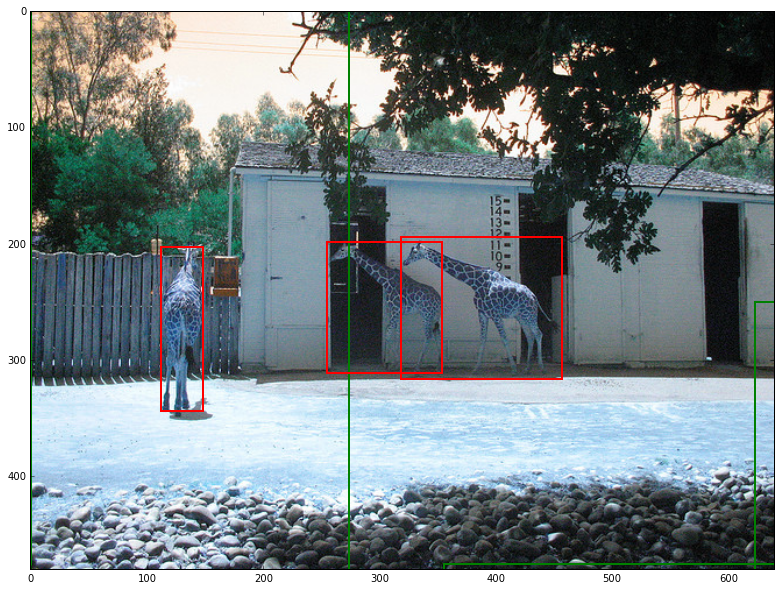

In [58]:
fig,ax = plt.subplots(1, figsize=(20, 10))
base_path = './data/mscoco/images/train2014/'
img_path = os.path.join(base_path, blobs['im_name'])
# Display the image
im_data = cv2.imread(img_path)

ax.imshow(im_data)
# Create a Rectangle patch
for i, box in enumerate(box_data):
    box = box[1:]
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1] ,linewidth=2,edgecolor='g',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    
for i, box in enumerate(origin_gt_box):
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1]  ,linewidth=2,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    
plt.show()

# debug max overlap